# Spatial Analysis in Julia

Julia has a growing spatial analysis ecosystem.

Especially for raster operations, Julia has most of the functionality that R and Python have in their ecosystems. At the same time, it extremely fast (outperforming R and Python by a factor of 10 or more in many basic operations), geared to working with big data (including lazy loading), and has great plotting with the Makie library.

<img src="https://github.com/user-attachments/assets/1c6c56ac-4c5a-4096-984d-15bf2783682c" width = 50%>


Julia is very modular, with packages depending on and extending each other.
In Julia, there is not a single package that does all geospatial analysis like R's terra. Instead, you get to choose which functionality you need and install those packages.

Here, we will rely on the following packages:
- [Rasters.jl](https://github.com/rafaqz/Rasters.jl/), for raster data analysis
- [GeoDataFrames.jl](https://github.com/evetion/GeoDataFrames.jl), for conveniently loading and writing vector data
- [GeometryOps.jl](https://github.com/JuliaGeo/GeometryOps.jl), which does basic vector data operations (e.g. calculating area, buffer, centroids)
- [CairoMakie.jl](https://github.com/MakieOrg/Makie.jl), which is a great plotting library
- [RasterDataSources.jl](https://github.com/EcoJulia/RasterDataSources.jl/), which is a convenient way to download raster data to your computer
- [GADM.jl](https://github.com/JuliaGeo/GADM.jl), which we use to download administrative data (county boundaries etc)
- [ArchGDAL.jl](https://github.com/yeesian/ArchGDAL.jl), which is built on top of the GDAL library, and is necessary for loading .tif files

### Installing packages

Julia comes with a built-in environment and package manager. It will figure out which versions of packages are compatible with each other and install those. To use the package manager, use `]` followed by a command if you are using the REPL. The package manager is itself a package `Pkg`, so we can also import it and use it that way.

Since this directory has a `Project.toml` file which specifies which packages 

Executing this takes a few minutes - it will install all the packages and precompile them.


In [3]:
import Pkg # The package manager is itself a package
Pkg.activate(".") # Activate the current directory as a package environment
Pkg.instantiate() # Install dependencies

  Activating project at `c:\Users\tsh371\Documents\julia-workshop`


# Import packages
There are 2 commands to import packages, these are `using` and `import`.

`using` will make all the names (e.g. functions) in the package available, while `import` will import the package, but any names have to be accessed as `Package.function`.

Here, since we will use `Rasters` and `DataFrames` directly, we will use `using` for those. `ArchGDAL` is only need to load tif files, so we will just use `import` for that.

In [1]:
using Rasters, DataFrames, CairoMakie
import ArchGDAL

# Our first Raster
Let's make a very simple Raster.

First we create an X and a Y dimension - each with numbers 1 to 10.

We then create a dimensional array with `rand` (thanks to the power of multiple dispatch, rand has a specialized implementation when called with dimensions!). Finally we wrap in `Raster` to create a raster.

In [4]:
xdim, ydim = X(1:10), Y(1:10)
ras = Raster(rand(xdim, ydim))

┌ 10×10 Raster{Float64, 2} ┐
├──────────────────────────┴───────────────────────────────────────────── dims ┐
  ↓ X Sampled{Int64} 1:10 ForwardOrdered Regular Points,
  → Y Sampled{Int64} 1:10 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10))
└──────────────────────────────────────────────────────────────────────────────┘
  ↓ →  1         2         3         …  8         9         10
  1    0.103308  0.808653  0.895138     0.65901   0.122955   0.876467
  2    0.333874  0.763751  0.540117     0.480598  0.585624   0.611361
  3    0.692527  0.554806  0.822507     0.64878   0.115434   0.925629
  4    0.38747   0.566229  0.482418     0.207707  0.564836   0.784965
  5    0.165733  0.238851  0.844284  …  0.350733  0.209209   0.612812
  6    0.344509  0.696324  0.540597     0.425428  0.682452   0.361247
  7    0.921527  0.857781  0.779706     0.568228  0.798453   0.411408
  8    0.375449  0.

`Raster` objects in Julia store an array, and have dimensions associated.

Dimensions could be longitude and latitude (X and Y), but a Raster could have many more dimensions.

Rasters can have more information associated with them, such as their crs.

Let's make a 4-dimensional Raster, that also has a crs and a name

In [5]:
using Dates
zdim = Z(1:2)
tidim = Ti(Date(2000, 1, 1):Month(1):Date(2010,1,1))
ras2 = Raster(rand(xdim, ydim, zdim, tidim), crs = EPSG(4326), name = :my_first_raster)

┌ 10×10×2×121 Raster{Float64, 4} my_first_raster ┐
├────────────────────────────────────────────────┴─────────────────────── dims ┐
  ↓ X  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  → Y  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  ↗ Z  Sampled{Int64} 1:2 ForwardOrdered Regular Points,
  ⬔ Ti Sampled{Date} Date("2000-01-01"):Month(1):Date("2010-01-01") ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10), Z = (1, 2), Ti = (Date("2000-01-01"), Date("2010-01-01")))
  crs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1]
  ↓ →  1         2         3         …  8         9          10
  1    0.73773   0.253285  0.558722     0.126479  0.845518    0.977185
  2    0.682517  0.624297  0.815997     0.367903  0.364574    0.235709
  3    0.878762  0.582953  0.480291     0.699649  0.565867    0.703259
  ⋮                   

Since Rasters behave like Arrays, we can use the same indexing syntax:

In [6]:
ras2[2,5, 1, 1]

0.9372747817324788

Like Arrays, Rasters are _mutable_, which means we can change the values inside of them without creating a new Raster

In [7]:
ras2[1,1,1,1] = 1
ras2[1,2,1,1] = 0
ras2

┌ 10×10×2×121 Raster{Float64, 4} my_first_raster ┐
├────────────────────────────────────────────────┴─────────────────────── dims ┐
  ↓ X  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  → Y  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  ↗ Z  Sampled{Int64} 1:2 ForwardOrdered Regular Points,
  ⬔ Ti Sampled{Date} Date("2000-01-01"):Month(1):Date("2010-01-01") ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10), Z = (1, 2), Ti = (Date("2000-01-01"), Date("2010-01-01")))
  crs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1]
  ↓ →  1         2         3         …  8         9          10
  1    1.0       0.0       0.558722     0.126479  0.845518    0.977185
  2    0.682517  0.624297  0.815997     0.367903  0.364574    0.235709
  3    0.878762  0.582953  0.480291     0.699649  0.565867    0.703259
  ⋮                   

In addition, we can index by using the names of the variables. This is much more readable than the above.

If we index with only a subset of dimensions, this returns a subset of the Raster. To select the first time slice and the second z dimension, do:

In [8]:
ras2[Z = 2, Ti = 1]

┌ 10×10 Raster{Float64, 2} my_first_raster ┐
├──────────────────────────────────────────┴───────────────────────────── dims ┐
  ↓ X Projected{Int64} 1:10 ForwardOrdered Regular Points,
  → Y Projected{Int64} 1:10 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10))
  crs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
  ↓ →  1          2          3         …  8         9         10
  1    0.830488   0.0853972  0.951471     0.893889  0.17864    0.660847
  2    0.839515   0.294884   0.967432     0.583785  0.983328   0.222399
  3    0.713039   0.792099   0.954854     0.711311  0.823443   0.534751
  4    0.552639   0.786666   0.898643     0.474808  0.664967   0.779962
  5    0.227194   0.660055   0.648884  …  0.286568  0.441363   0.133255
  6    0.858443   0.528863   0.351029     0.784149  0.784586   0.639956
  7    0.504252   0.585395   0.753703 

There are different selectors available to select slices of a Raster based on the values of its dimensions. So if the want to select the slice that corresponds to May 2005 from this Raster, we can select like this:

In [9]:
ras2[Ti = At(Date(2005, 5, 1))]

┌ 10×10×2 Raster{Float64, 3} my_first_raster ┐
├────────────────────────────────────────────┴─────────────────────────── dims ┐
  ↓ X Projected{Int64} 1:10 ForwardOrdered Regular Points,
  → Y Projected{Int64} 1:10 ForwardOrdered Regular Points,
  ↗ Z Sampled{Int64} 1:2 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10), Z = (1, 2))
  crs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1]
  ↓ →  1          2          3           …  8         9         10
  1    0.152086   0.927588   0.509694       0.207196  0.251855   0.281221
  2    0.508374   0.132915   0.292783       0.754768  0.870541   0.416884
  3    0.287651   0.742251   0.00188907     0.356914  0.566671   0.907916
  4    0.121041   0.57789    0.852585       0.841546  0.927649   0.00404497
  ⋮                                      ⋱                       ⋮
  7    0.823806   0.937

Broadcasting operations over a Raster return another Raster.

We can also use broadcasting to change the values in the Raster

In [10]:
ras3 = ras2 .+ 1 # this returns a brand new Raster

┌ 10×10×2×121 Raster{Float64, 4} ┐
├────────────────────────────────┴─────────────────────────────────────── dims ┐
  ↓ X  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  → Y  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  ↗ Z  Sampled{Int64} 1:2 ForwardOrdered Regular Points,
  ⬔ Ti Sampled{Date} Date("2000-01-01"):Month(1):Date("2010-01-01") ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10), Z = (1, 2), Ti = (Date("2000-01-01"), Date("2010-01-01")))
  crs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1]
  ↓ →  1        2        3        …  7        8        9        10
  1    2.0      1.0      1.55872     1.82503  1.12648  1.84552   1.97718
  2    1.68252  1.6243   1.816       1.52234  1.3679   1.36457   1.23571
  3    1.87876  1.58295  1.48029     1.28597  1.69965  1.56587   1.70326
  ⋮                          

Of course we can both index by a dimension name, and mutate the raster. Here, we set the entire slice where X is equal to 2 to 0

In [11]:
ras2[X = At(2)] .= 0 # this is a mutating operation - it changes the values of the gridcells
ras2

┌ 10×10×2×121 Raster{Float64, 4} my_first_raster ┐
├────────────────────────────────────────────────┴─────────────────────── dims ┐
  ↓ X  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  → Y  Projected{Int64} 1:10 ForwardOrdered Regular Points,
  ↗ Z  Sampled{Int64} 1:2 ForwardOrdered Regular Points,
  ⬔ Ti Sampled{Date} Date("2000-01-01"):Month(1):Date("2010-01-01") ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 10), Y = (1, 10), Z = (1, 2), Ti = (Date("2000-01-01"), Date("2010-01-01")))
  crs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1]
  ↓ →  1         2         3         …  8         9          10
  1    1.0       0.0       0.558722     0.126479  0.845518    0.977185
  2    0.0       0.0       0.0          0.0       0.0         0.0
  3    0.878762  0.582953  0.480291     0.699649  0.565867    0.703259
  ⋮                        

# Load elevation data
Let's load our first real dataset - an elevation dataset from WorldClim.

We'll use the [RasterDataSources](https://github.com/EcoJulia/RasterDataSources.jl) package to conveniently handle the downloading of Rasters for us.

We need to define a path were downloaded files will be stored - usually this would be some path on your computer or hard drive.

In [12]:
using RasterDataSources
ENV["RASTERDATASOURCES_PATH"] = "." # downloaded files are stored here

"."

The `getraster` function in RasterDataSources downloads a dataset, and returns the file path where the Raster is stored

In [13]:
filepath_elev = getraster(WorldClim{Elevation}, :elev)

".\\WorldClim\\Elevation\\wc2.1_10m_elev.tif"

Calling `Raster` with a filepath argument reads in the data

In [14]:
elev = Raster(filepath_elev, name = :elev)

┌ 2160×1080 Raster{Union{Missing, Int16}, 2} elev ┐
├─────────────────────────────────────────────────┴────────────────────── dims ┐
  ↓ X Projected{Float64} -180.0:0.16666666666666666:179.83333333333331 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 89.83333333333333:-0.16666666666666666:-90.0 ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => ".\\WorldClim\\Elevation\\wc2.1_10m_elev.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
    ↓ →    89.8333    89.6667    89.5       …   -89.6667   -89.8333   -90.0
 -180.0      missing    mis

Rasters integrates with RasterDataSources, so it is possible to construct a Raster (and download the data if necessary) by providing the datasource and the layer as positional arguments.

In [15]:
elev = Raster(WorldClim{Elevation}, :elev)

┌ 2160×1080 Raster{Union{Missing, Int16}, 2} elev ┐
├─────────────────────────────────────────────────┴────────────────────── dims ┐
  ↓ X Projected{Float64} -180.0:0.16666666666666666:179.83333333333331 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 89.83333333333333:-0.16666666666666666:-90.0 ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => ".\\WorldClim\\Elevation\\wc2.1_10m_elev.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
    ↓ →    89.8333    89.6667    89.5       …   -89.6667   -89.8333   -90.0
 -180.0      missing    mis

Let's do some basic exploration of this data. The first thing we would do is to plot it

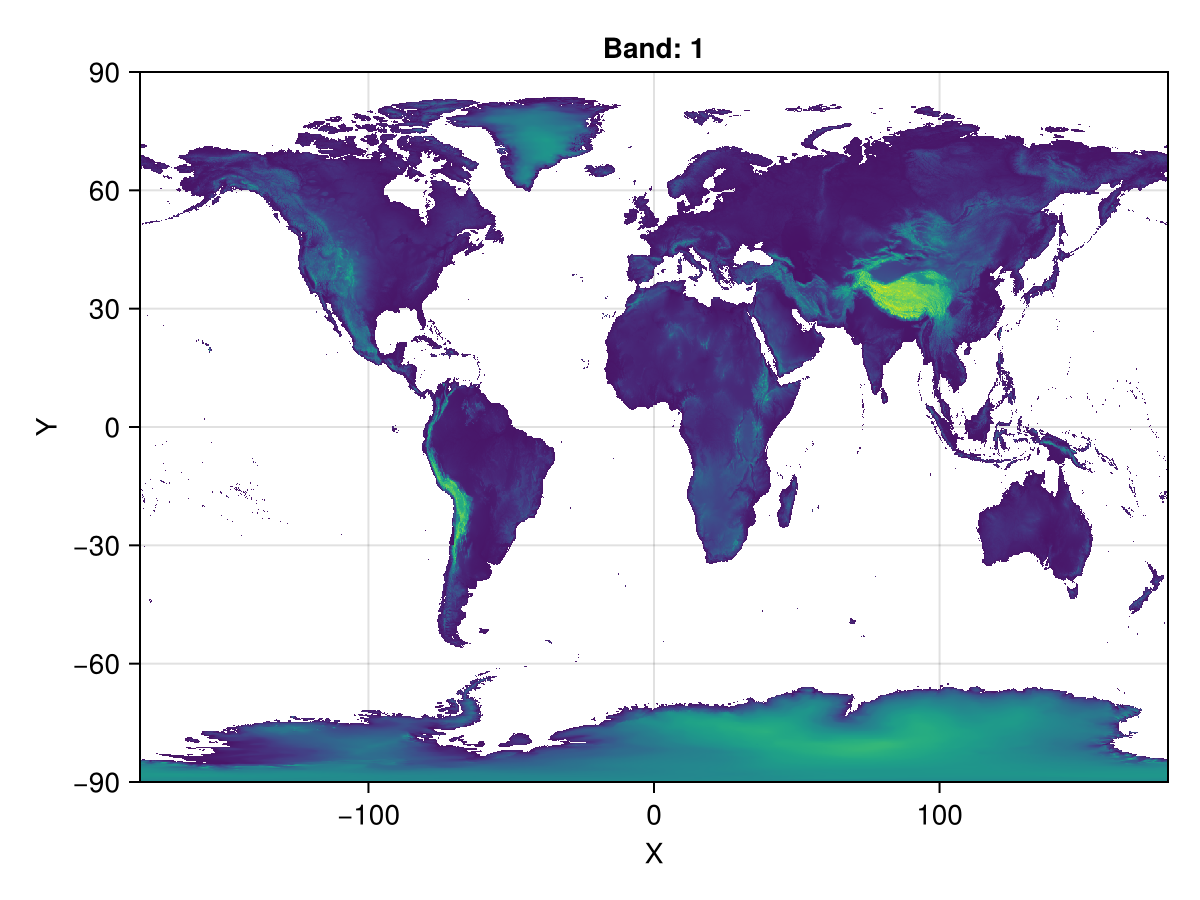

In [16]:
using CairoMakie
plot(elev)

Looks okay, but it doesn't tell us what units this data has, for example. Let's look for the highest and lowest point on the planet

In [17]:
extrema(elev)

(missing, missing)

Because some of the cells are have missing values, we need to wrap our raster in `skipmissing` so missing values are ignored

In [18]:
extrema(skipmissing(elev))

(-352, 6251)

Interestingly, some areas of the world are below see level. We can use broadcasting to identify cells that have values below 0

In [19]:
below_sea_level = elev .< 0

┌ 2160×1080 Raster{Union{Missing, Bool}, 2} ┐
├───────────────────────────────────────────┴──────────────────────────── dims ┐
  ↓ X Projected{Float64} -180.0:0.16666666666666666:179.83333333333331 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 89.83333333333333:-0.16666666666666666:-90.0 ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => ".\\WorldClim\\Elevation\\wc2.1_10m_elev.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
    ↓ →    89.8333    89.6667    …  -89.5  -89.6667  -89.8333  -90.0
 -180.0      missing    missing       0 

This created a Raster with `true` and `false` values. We can again explore and visualize this Raster.

How many pixels are below sea level?

In [20]:
count(skipmissing(below_sea_level))

2691

In julia, functions like mean, sum, and count can take a function as their first argument, which is applied to each element before taking the mean/sum/count. So an alternative way to do this is:

In [21]:
count(<(0), skipmissing(elev)) # count values in `elev` that are below 0

2691

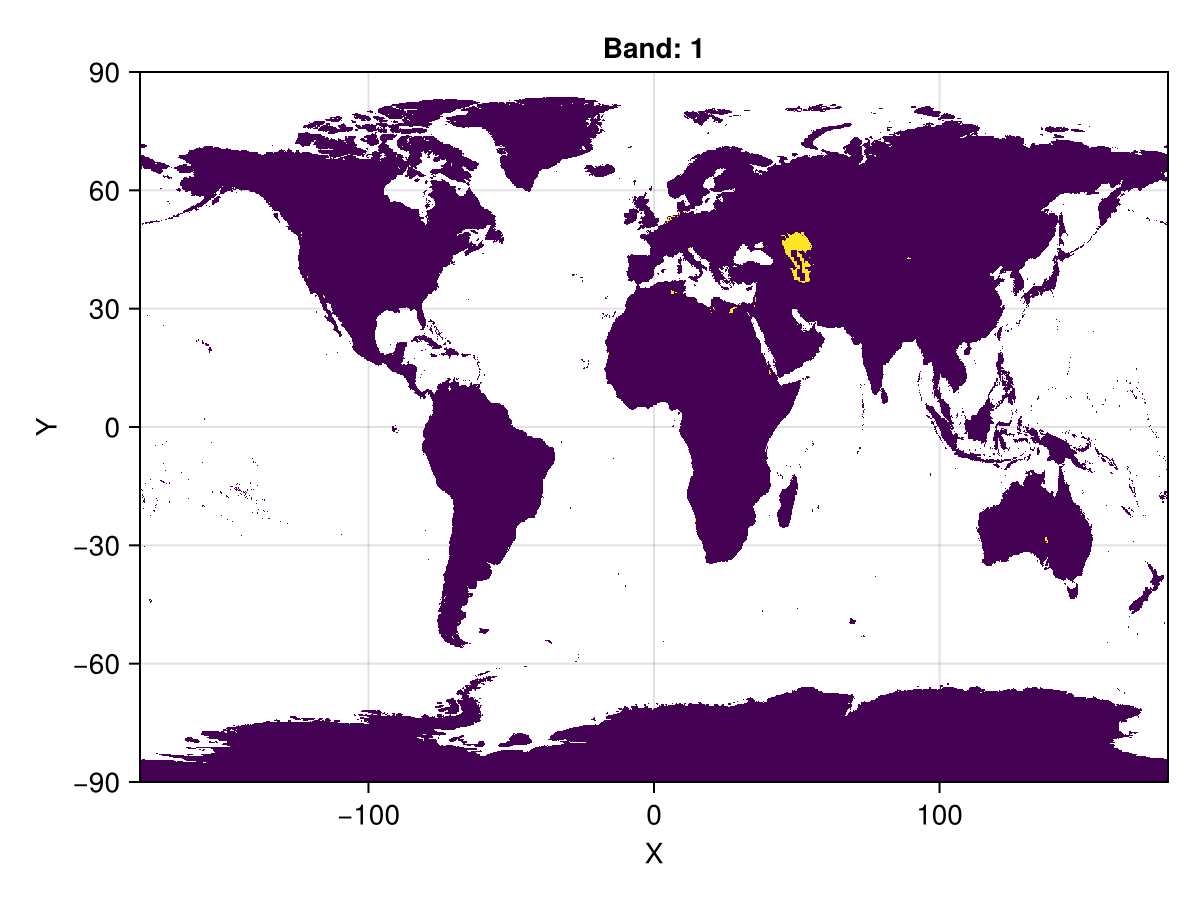

In [22]:
plot(below_sea_level)

## Exercise:
Explore this data a little more. **How many pixels are above 5000 meters? Where are they?**

**What is the average elevation across all grid cells?**

**Which pixel has the highest elevation of all? What are the coordinates of that pixel?**

You will probably need some help from either Google or the Rasters documentation.

<details><summary>Reveal some hints</summary>

First use the `argmax` function to identify the index of the cell with highest value. You can also use `findmax` to get both the value and the index of that cell.

`DimPoints` returns a Raster with the coordinate locations of all Raster cells. Use the index you got to select the cell that has the highest value.
</details>

Our previous estimate of the average elevation is flawed, because we did not account for differences in the area of each grid cell. **Come up with a better estimate of the average elevation, taking into account the cell area of each grid cell**. 

Hint: the `cellarea` function computes the cell area (in metres^2) of every grid cell

In [23]:
# Your answers go here. Feel free to make additional cells

# Explore the elevation of Kenya

For the next part of this tutorial, we'll analyse Raster data for Kenya.

First, let's read in some administrative data for Kenya using the GADM package.

In [24]:
import GADM
kenya = GADM.get("KEN")

GADM.Table{Vector{Any}, WellKnownText{GeoFormatTypes.CRS}}(Any[Feature
  (index 0) geom => MULTIPOLYGON
  (index 0) GID_0 => KEN
  (index 1) COUNTRY => Kenya
], WellKnownText{GeoFormatTypes.CRS}(GeoFormatTypes.CRS(), "GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AXIS[\"Latitude\",NORTH],AXIS[\"Longitude\",EAST],AUTHORITY[\"EPSG\",\"4326\"]]"))

## Masking and cropping

Now let's use the `mask` function so we only select Kenya out of the original raster.

The mask function in Rasters takes a Raster as its first positional argumet, and can take one or multiply geometry/ies or another Raster as a keyword argument `with`.

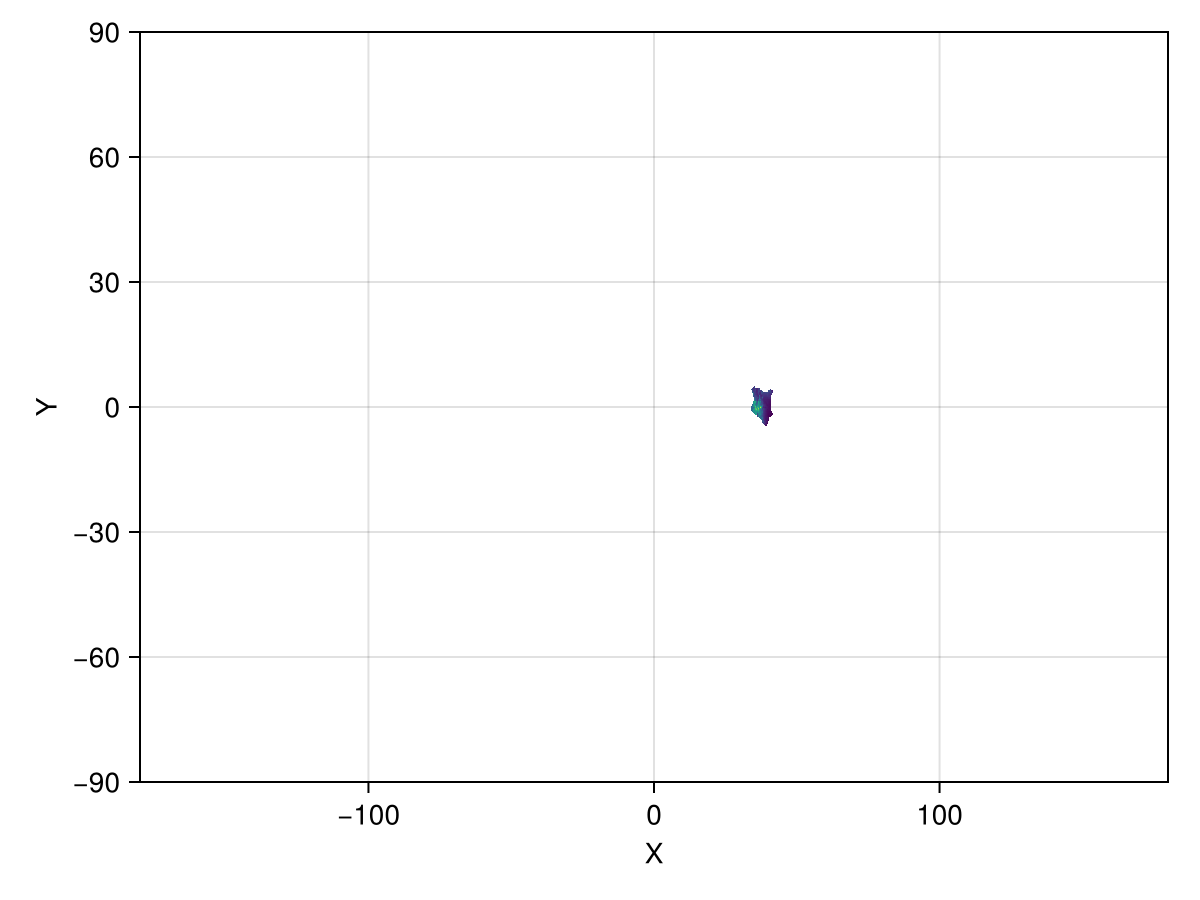

In [25]:
elev_kenya = mask(elev; with = kenya)
plot(elev_kenya)

This worked, but our Raster still has its initial size. To get rid of all of the missing values we can use `trim`.

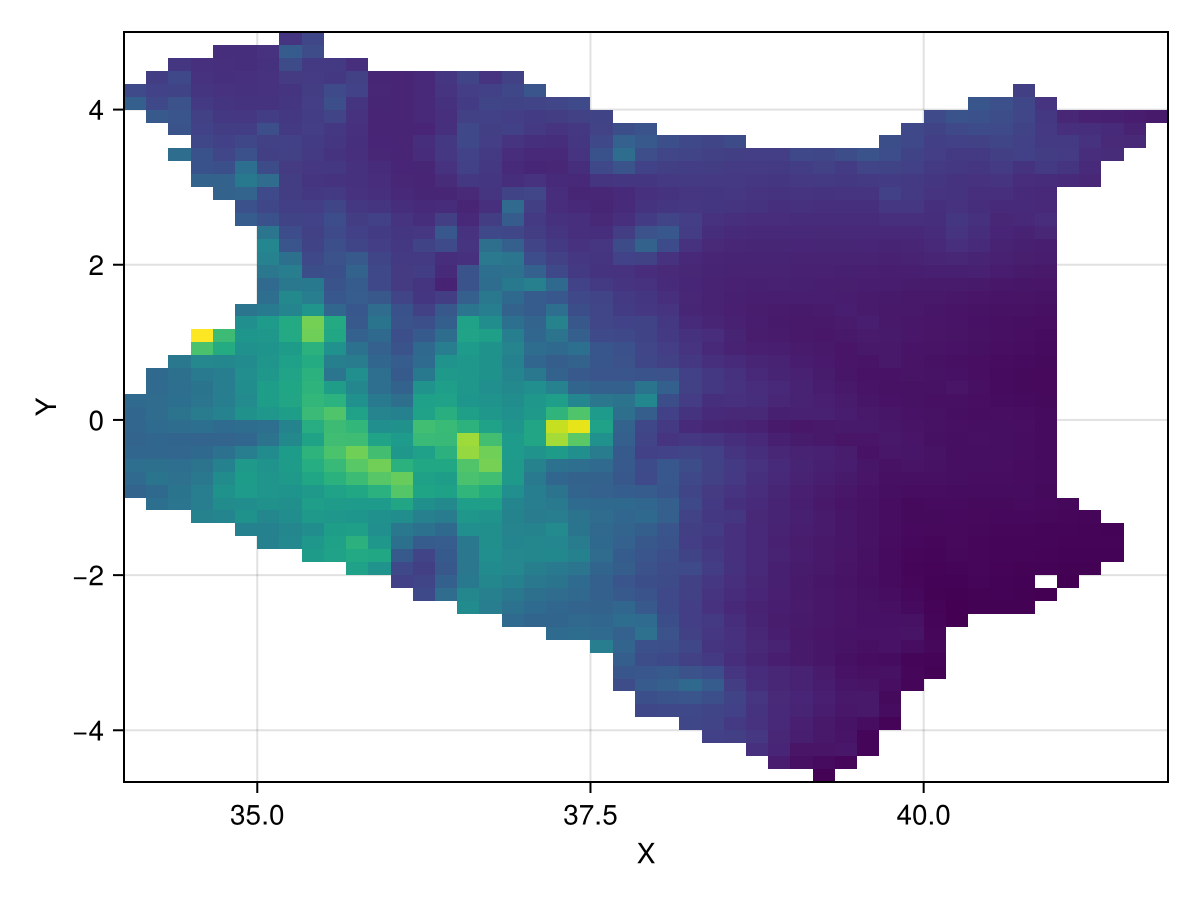

In [26]:
elev_kenya_trim = Rasters.trim(elev_kenya)
plot(elev_kenya_trim)

We can also just crop with the `crop` function. This takes a `to` keyword.

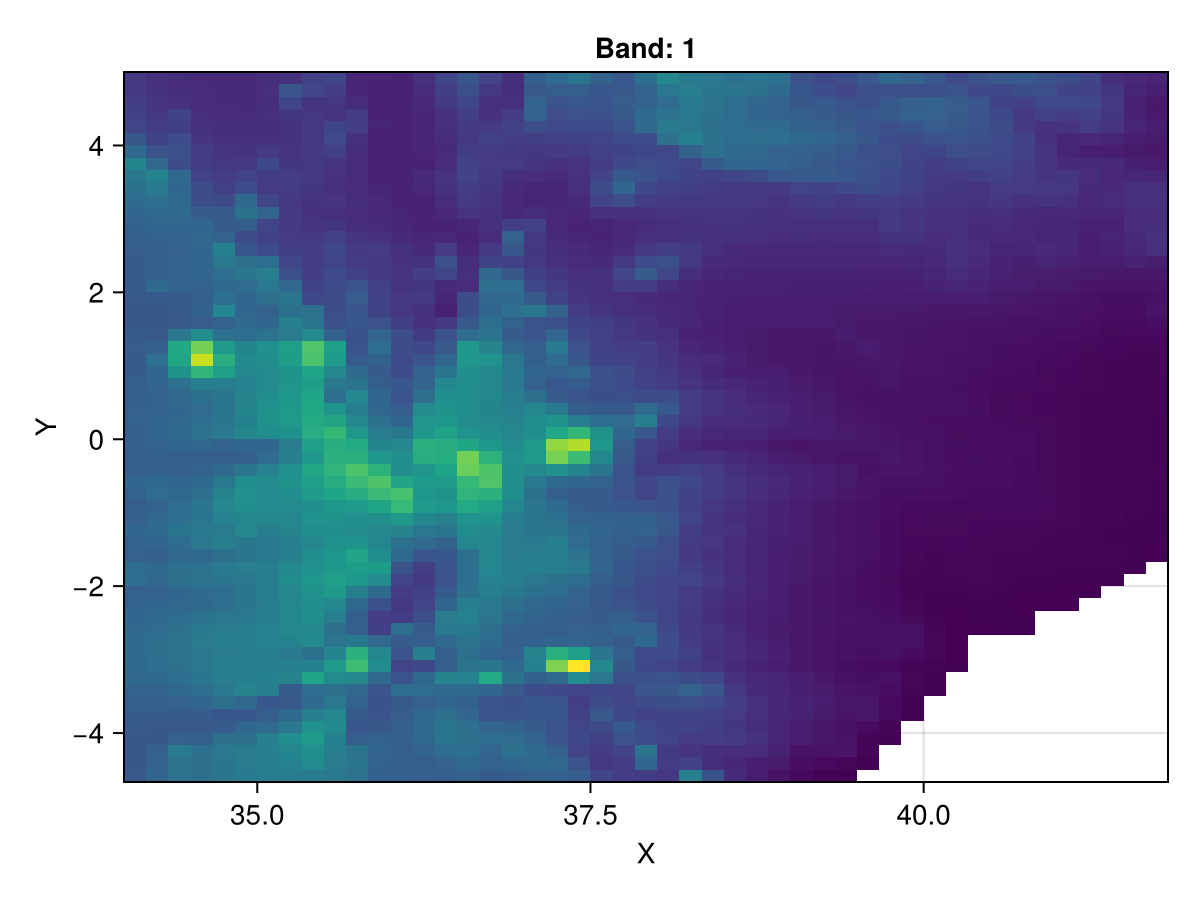

In [27]:
crop(elev; to = kenya) |> plot

# Elevation of all counties in Kenya
Let's do something a little bit more advanced with this elevation data.

Maybe we're interested in summarizing this data by showing the elevation of each county in Kenya.

We start of by using GADM again, but now with a depth argument that says we want the 1st level of adminstrative regions (counties).

We store this in a DataFrame so we can look at it more easily.

In [28]:
kenya_counties = GADM.get("KEN"; depth = 1) |> DataFrame

Row,geom,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1
,IGeometr…,String,String,String,String,String,String,String,String,String,String,String
1,Geometry: wkbMultiPolygon,KEN.1_1,KEN,Kenya,Baringo,NA,NA,County,County,30,KE.BA,KE-01
2,Geometry: wkbMultiPolygon,KEN.2_1,KEN,Kenya,Bomet,NA,NA,County,County,36,KE.BO,KE-02
3,Geometry: wkbMultiPolygon,KEN.3_1,KEN,Kenya,Bungoma,NA,NA,County,County,39,KE.BN,KE-03
4,Geometry: wkbMultiPolygon,KEN.4_1,KEN,Kenya,Busia,NA,NA,County,County,40,KE.BS,KE-04
5,Geometry: wkbMultiPolygon,KEN.5_1,KEN,Kenya,Elgeyo-Marakwet,NA,NA,County,County,28,KE.EM,NA
6,Geometry: wkbMultiPolygon,KEN.6_1,KEN,Kenya,Embu,NA,NA,County,County,14,KE.EB,KE-06
7,Geometry: wkbMultiPolygon,KEN.7_1,KEN,Kenya,Garissa,NA,NA,County,County,7,KE.GA,KE-07
8,Geometry: wkbMultiPolygon,KEN.8_1,KEN,Kenya,Homa Bay,NA,NA,County,County,43,KE.HB,KE-08
9,Geometry: wkbMultiPolygon,KEN.9_1,KEN,Kenya,Isiolo,NA,NA,County,County,11,KE.IS,KE-09


Makie very easily plots geometries.

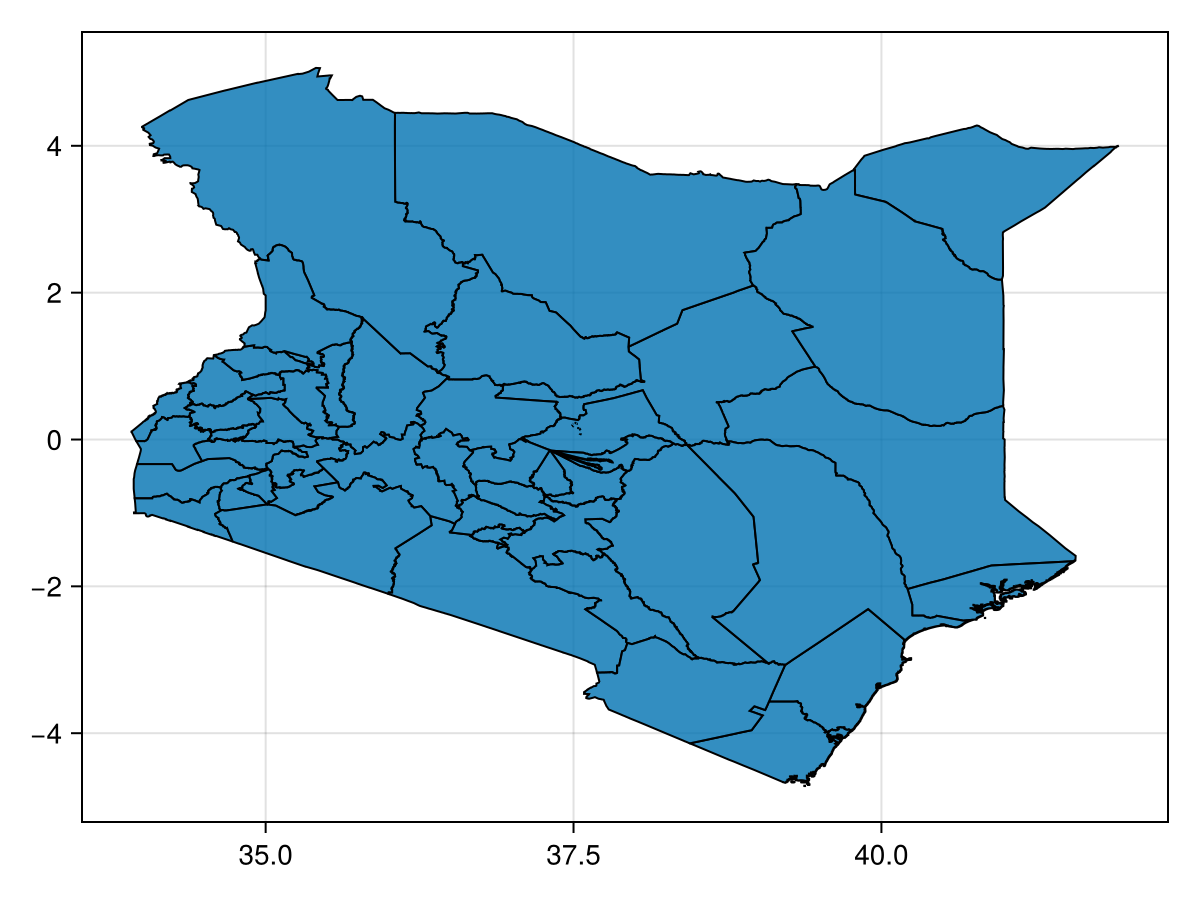

In [29]:
plot(kenya_counties.geom, strokewidth = 1)

Now, we use the `zonal` function from the Rasters package to summarize our elevation raster using a function we provide (here: `mean`) for each of the counties. We store this in a new column of the DataFrame.

Zonal has 3 obligatory arguments:
- The first positional argument is a function used to calculate the zonal statistic
- The second positional argument is the Raster
- The `of` keyword argument is an iterable (e.g. vector) containing geometries

In [30]:
using Statistics: mean
kenya_counties.elevation = zonal(mean, elev; of = kenya_counties.geom)
kenya_counties

Applying mean to each geometry... 100%|██████████████████████████████████████████████████| Time: 0:00:00


Row,geom,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,elevation
,IGeometr…,String,String,String,String,String,String,String,String,String,String,String,Float64?
1,Geometry: wkbMultiPolygon,KEN.1_1,KEN,Kenya,Baringo,NA,NA,County,County,30,KE.BA,KE-01,1408.34
2,Geometry: wkbMultiPolygon,KEN.2_1,KEN,Kenya,Bomet,NA,NA,County,County,36,KE.BO,KE-02,2010.22
3,Geometry: wkbMultiPolygon,KEN.3_1,KEN,Kenya,Bungoma,NA,NA,County,County,39,KE.BN,KE-03,1934.8
4,Geometry: wkbMultiPolygon,KEN.4_1,KEN,Kenya,Busia,NA,NA,County,County,40,KE.BS,KE-04,1262.75
5,Geometry: wkbMultiPolygon,KEN.5_1,KEN,Kenya,Elgeyo-Marakwet,NA,NA,County,County,28,KE.EM,NA,1956.89
6,Geometry: wkbMultiPolygon,KEN.6_1,KEN,Kenya,Embu,NA,NA,County,County,14,KE.EB,KE-06,1272.62
7,Geometry: wkbMultiPolygon,KEN.7_1,KEN,Kenya,Garissa,NA,NA,County,County,7,KE.GA,KE-07,151.133
8,Geometry: wkbMultiPolygon,KEN.8_1,KEN,Kenya,Homa Bay,NA,NA,County,County,43,KE.HB,KE-08,1275.85
9,Geometry: wkbMultiPolygon,KEN.9_1,KEN,Kenya,Isiolo,NA,NA,County,County,11,KE.IS,KE-09,468.597


We can now sort this dataframe so it is ordered by elevation. 

The `sort!` function comes from the DataFrames package. By convention, the `!` indicates that it is a _mutating_ function. Instead of creating a new DataFrame, it changes the DataFrame that is supplied.

In [31]:
# Sort to see which counties have low and high elevations.
sort!(kenya_counties, :elevation)

Row,geom,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,elevation
,IGeometr…,String,String,String,String,String,String,String,String,String,String,String,Float64?
1,Geometry: wkbMultiPolygon,KEN.21_1,KEN,Kenya,Lamu,NA,NA,County,County,5,KE.LM,KE-21,21.8571
2,Geometry: wkbMultiPolygon,KEN.28_1,KEN,Kenya,Mombasa,NA,NA,County,County,1,KE.MM,KE-28,43.0
3,Geometry: wkbMultiPolygon,KEN.14_1,KEN,Kenya,Kilifi,NA,NA,County,County,3,KE.KF,KE-14,140.921
4,Geometry: wkbMultiPolygon,KEN.7_1,KEN,Kenya,Garissa,NA,NA,County,County,7,KE.GA,KE-07,151.133
5,Geometry: wkbMultiPolygon,KEN.40_1,KEN,Kenya,Tana River,NA,NA,County,County,4,KE.TR,KE-40,209.354
6,Geometry: wkbMultiPolygon,KEN.19_1,KEN,Kenya,Kwale,NA,NA,County,County,2,KE.KW,KE-19,244.864
7,Geometry: wkbMultiPolygon,KEN.46_1,KEN,Kenya,Wajir,NA,NA,County,County,8,KE.WJ,KE-46,318.305
8,Geometry: wkbMultiPolygon,KEN.9_1,KEN,Kenya,Isiolo,NA,NA,County,County,11,KE.IS,KE-09,468.597
9,Geometry: wkbMultiPolygon,KEN.24_1,KEN,Kenya,Mandera,NA,NA,County,County,9,KE.MD,KE-24,559.184


We can color-code the counties by their elevation by passing the elevation as a keywords argument to `color`.

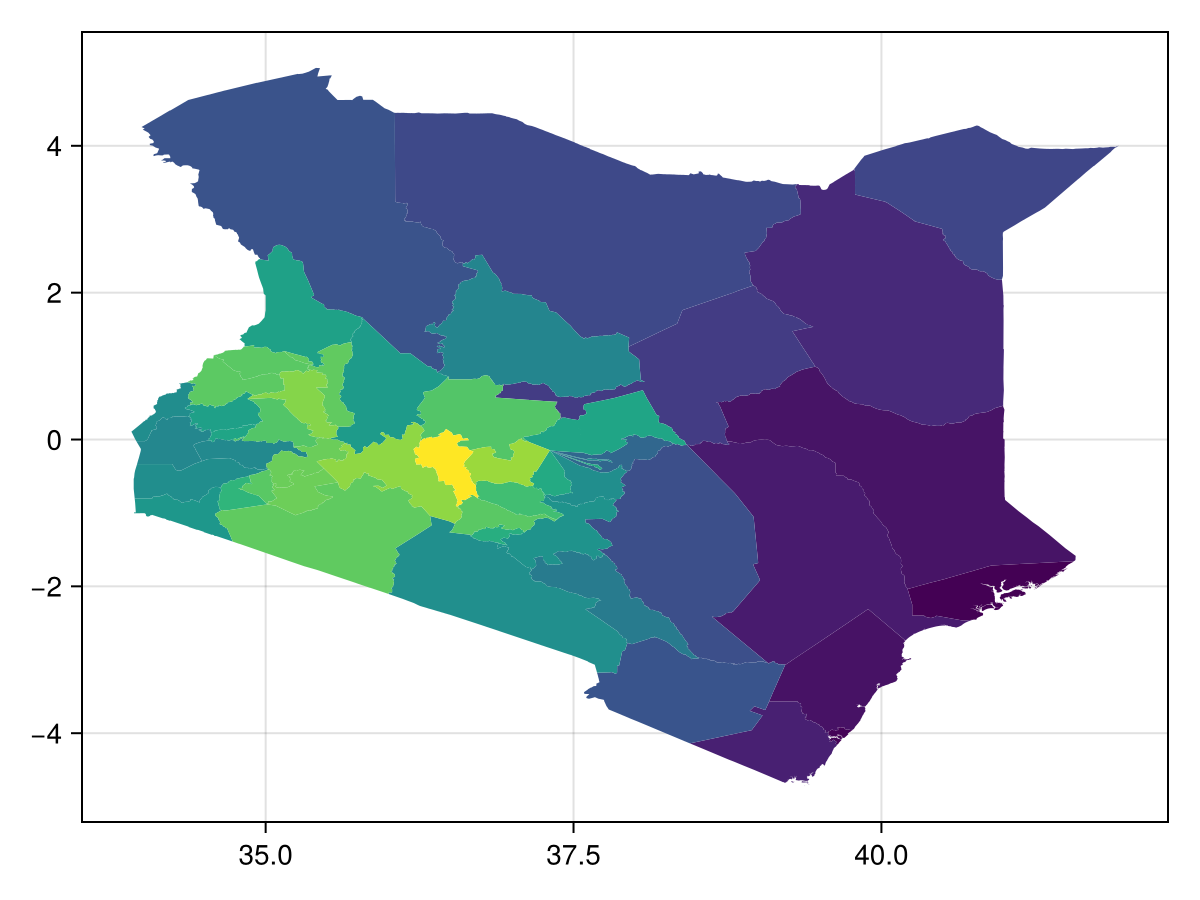

In [32]:
plot(kenya_counties.geom; color = Float64.(kenya_counties.elevation))

# RasterStack and RasterSeries

There are 2 other important Raster data structures: stacks and series.

Stacks of Rasters are a named collection of Rasters with some shared dimensions. If dimensions are shared between Rasters, they must be identical. Often, each layer in the stack represents some variable. Internally, these are stored as a NamedTuple of Rasters.

Series of Rasters are a collection of Rasters along some dimension - e.g. a time series. This can be useful if you have lots of files, for example with daily records. This is similar to an 'array of arrays' structure.

For both stacks and series, functions like crop and mask are applied to all rasters they contain. Functions like zonal and extract (more on extract later) are also implemented for stacks.

Here we load a RasterStack with 1 month of data for temperature, precipitation, and solar radiation. Each of these variables are a layer in the stack.

We use a similar constructor from RasterDataSources

In [33]:
bioc = RasterStack(WorldClim{Climate}, (:tavg, :prec, :srad); month = 1)

┌ 2160×1080 RasterStack ┐
├───────────────────────┴──────────────────────────────────────────────── dims ┐
  ↓ X Projected{Float64} -180.0:0.16666666666666666:179.83333333333331 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 89.83333333333333:-0.16666666666666666:-90.0 ReverseOrdered Regular Intervals{Start}
├────────────────────────────────────────────────────────────────────── layers ┤
  :tavg eltype: Union{Missing, Float32} dims: X, Y size: 2160×1080
  :prec eltype: Union{Missing, Int16} dims: X, Y size: 2160×1080
  :srad eltype: Union{Missing, UInt16} dims: X, Y size: 2160×1080
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘

Retrieving a layer from a RasterStack returns Raster. You can do this by simply indexing, just as if it were a NamedTuple

In [34]:
# Indexing a RasterStack by layer names returns a Rasters
bioc.tavg

┌ 2160×1080 Raster{Union{Missing, Float32}, 2} tavg ┐
├───────────────────────────────────────────────────┴──────────────────── dims ┐
  ↓ X Projected{Float64} -180.0:0.16666666666666666:179.83333333333331 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 89.83333333333333:-0.16666666666666666:-90.0 ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => ".\\WorldClim\\Climate\\tavg\\wc2.1_10m_tavg_01.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
    ↓ →    89.8333    89.6667    89.5       …  -89.6667  -89.8333  -90.0
 -180.0      missing 

Now to download this climate data for all 12 months, we use a RasterSeries constructor.

Here, every element in the series is a RasterStack with 1 month of data.

In [35]:
bioc_series = RasterSeries(WorldClim{Climate}, (:tavg, :prec, :srad); month = 1:12)

┌ 12-element RasterSeries{RasterStack,1} ┐
├────────────────────────────────────────┴─────────────────────────────── dims ┐
  ↓ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
  1  …  RasterStack{(:tavg, :prec, :srad), @NamedTuple{tavg::Union{Missing, Float32}, prec::Union{Missing, Int16}, srad::Union{Missing, UInt16}}, 2, @NamedTuple{tavg::ReshapedArray{Union{Missing, Float32}, 2, Array{Union{Missing, Float32}, 3}, Tuple{}}, prec::ReshapedArray{Union{Missing, Int16}, 2, Array{Union{Missing, Int16}, 3}, Tuple{}}, srad::ReshapedArray{Union{Missing, UInt16}, 2, Array{Union{Missing, UInt16}, 3}, Tuple{}}}, Tuple{X{Projected{Float64, StepRangeLen{Float64,

Now let's mask and trim so we just get data for Kenya. We can do this on `RasterStack`s and `RasterSeries` the same was as for a `Raster`, and the operation will get applied to each element/layer.

In [36]:
# We can mask as if this was a normal Raster
bioc_series_kenya = Rasters.trim(mask(bioc_series; with = kenya))

┌ 12-element RasterSeries{RasterStack,1} ┐
├────────────────────────────────────────┴─────────────────────────────── dims ┐
  ↓ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.999999999999986, 41.83333333333332), Y = (-4.666666666666667, 5.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
  1  …  RasterStack{(:tavg, :prec, :srad), @NamedTuple{tavg::Union{Missing, Float32}, prec::Union{Missing, Int16}, srad::Union{Missing, UInt16}}, 2, @NamedTuple{tavg::SubArray{Union{Missing, Float32}, 2, Matrix{Union{Missing, Float32}}, Tuple{UnitRange{Int64}, UnitRange{Int64}}, false}, prec::SubArray{Union{Missing, Int16}, 2, Matrix{Union{Missing, Int16}}, Tuple{UnitRange{Int64}, UnitRange{Int64}}, false}, srad::SubArray{Union{Missing, UInt16}, 2, Matrix{

Sometimes Rasters are a little easier to work with. If all elements of a `RasterStack` have identical dimensions, then it trivial to combine them all into a single `Raster`/`RasterStack` using `Rasters.combine`

In [37]:
# Combine the RasterSeries into a single Raster
bioc_kenya = Rasters.combine(bioc_series_kenya)

┌ 47×58×12 RasterStack ┐
├──────────────────────┴───────────────────────────────────────────────── dims ┐
  ↓ X     Projected{Float64} 33.999999999999986:0.16666666666666666:41.66666666666666 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 4.833333333333333:-0.16666666666666666:-4.666666666666667 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :tavg eltype: Union{Missing, Float32} dims: X, Y, month size: 47×58×12
  :prec eltype: Union{Missing, Int16} dims: X, Y, month size: 47×58×12
  :srad eltype: Union{Missing, UInt16} dims: X, Y, month size: 47×58×12
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.999999999999986, 41.83333333333332), Y = (-4.666666666666667, 5.0), month = (1, 12))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298

Other than bands in a single Raster, layer in a RasterStack can have different types. Here solar radiation is a UInt16 (unsigned integer), and temperature is a floating point number.

Not all bands have to share all dimensions - we can add a band that has the number of days per month - this one just has a month dimension, but no X or Y dimensions.

In [38]:
days_per_month = Raster([31,30,31,28,31,30,31,31,30,31,30,31], Dim{:month}(1:12); name = :ndays)

┌ 12-element Raster{Int64, 1} ndays ┐
├───────────────────────────────────┴──────────────────────────────────── dims ┐
  ↓ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(month = (1, 12),)
└──────────────────────────────────────────────────────────────────────────────┘
  1  31
  2  30
  3  31
  4  28
  5  31
  6  30
  7  31
  8  31
  9  30
 10  31
 11  30
 12  31

In [39]:
println("let's check we have the right number of days: $(sum(days_per_month))")
# make a new rasterstack with the layers of the old one, and a new raster
rs_kenya = RasterStack(layers(bioc_kenya)..., days_per_month)

let's check we have the right number of days: 365


┌ 47×58×12 RasterStack ┐
├──────────────────────┴───────────────────────────────────────────────── dims ┐
  ↓ X     Projected{Float64} 33.999999999999986:0.16666666666666666:41.66666666666666 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 4.833333333333333:-0.16666666666666666:-4.666666666666667 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :tavg  eltype: Union{Missing, Float32} dims: X, Y, month size: 47×58×12
  :prec  eltype: Union{Missing, Int16} dims: X, Y, month size: 47×58×12
  :srad  eltype: Union{Missing, UInt16} dims: X, Y, month size: 47×58×12
  :ndays eltype: Int64 dims: month size: 12
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: (tavg = missing, prec = missing, srad = missing, ndays = nothing)
  extent: Extent(X = (33.999999999999986, 41.83333333333332), Y = (-4.6666

# Estimating fascioliasis risk in Kenya
Fascioliasis (liver fluke) is a snail-borne parasitic disease that affects cattle. 

[Malone et al. (1998)](10.1016/s0304-4017(98)00137-x) define a simple risk index for this disease:

$$
\text{riskindex} =
\begin{cases} 
\text{GDD} \cdot \text{days in month}, & \text{if } R > (PET \cdot 0.8) \\
\text{GDD} \cdot \text{days in month} + \frac{(\text{GDD} \cdot 6) \cdot (R - PET)}{25}, & \text{if } R > PET \\
0, & \text{otherwise}
\end{cases}
$$


where GDD is the number of Growing Degree Days, R is precipitation, and PET is potential evapotranspiration.

There are two species that cause liver fluke: _Fasciola hepatica_ and _Fasciola gigantica_. The GDD threshold for _F. hepatica_ is 10°C and for _F. gigantica_ it is 16°C.

The number of growing degree days is the temperature minus the GDD threshold (or 0, whichever is higher). High-risk zones might have monthly values above ~300.

WorldClim does not supply PET, but we can estimate it using the Hargreaves equation:
$$
PET = 0.0023 * (T_{mean} + 17.8) * \sqrt{T_{max} - T_{min}} * SR
$$

Where SR is solar radiation in MJ/m^2/day, and T is temperature in °C

To avoid having to download more data we will just assume that $T_{max} - T_{min}$ is 15

First we need to calculate PET. Let's define a function to calculate the Hargreaves equation

In [40]:
function hargreaves(sr, t; tdif = 10) 
    0.0023 * sr * (t + 17.8) * sqrt(tdif) # Hargreaves equation
end

hargreaves (generic function with 1 method)

In [41]:
daily_pet = hargreaves.(rs_kenya.srad ./ 1000, rs_kenya.tavg) # Hargreaves equation

┌ 47×58×12 Raster{Union{Missing, Float64}, 3} ┐
├─────────────────────────────────────────────┴────────────────────────── dims ┐
  ↓ X     Projected{Float64} 33.999999999999986:0.16666666666666666:41.66666666666666 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 4.833333333333333:-0.16666666666666666:-4.666666666666667 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.999999999999986, 41.83333333333332), Y = (-4.666666666666667, 5.0), month = (1, 12))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1]
  ↓ →     4.83333   4.66667   4.5       …  -4.33333   -4.5       -4.66667
 34.0      missing   missing   missing       missing    missing    missing
 34.1667   missing   mis

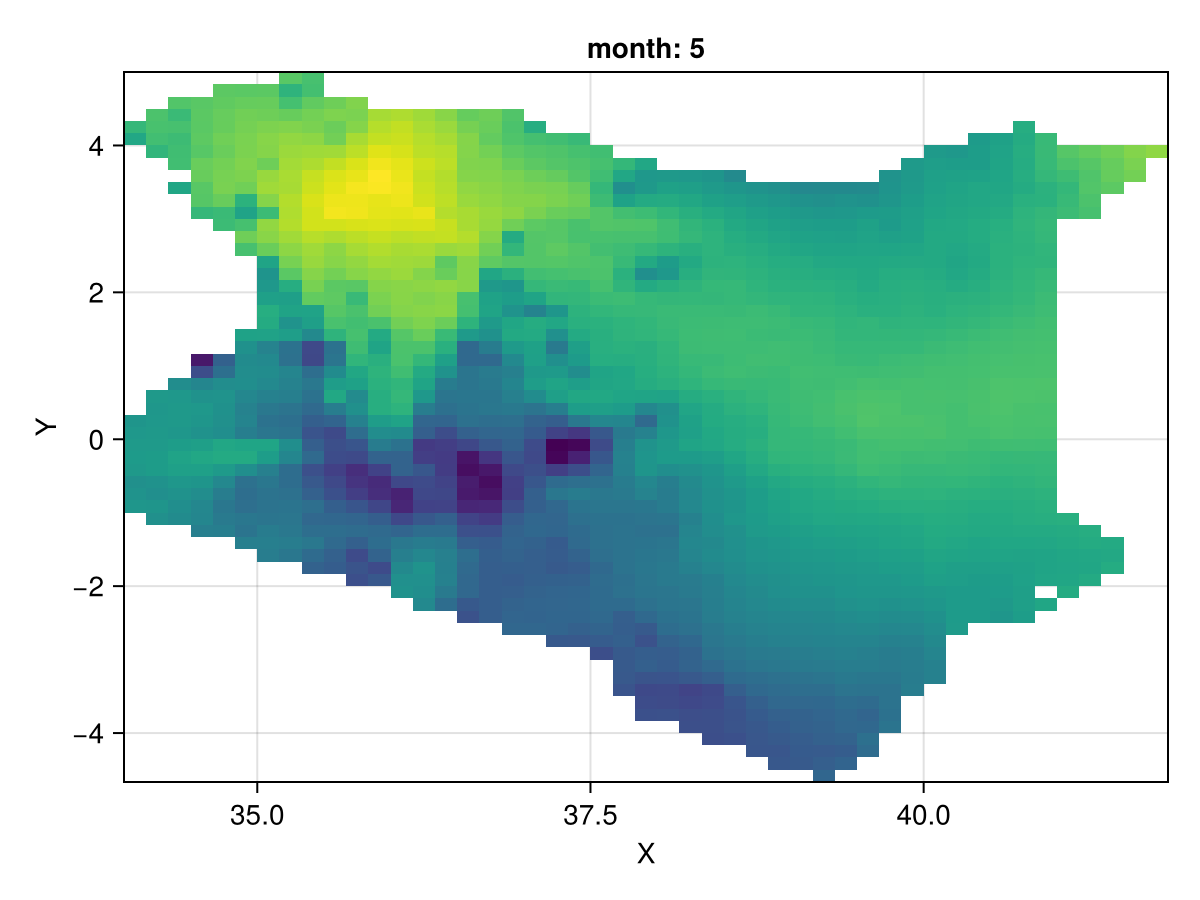

In [42]:
plot(daily_pet[month = 5])

We now need to correct for the number of days in each month - since our precipitation data is also per month.

We can do this by just multiplying the PET by the number of days in each month. To do this, we will use the `@d` macro before the broadcasted function. This transforms all the broadcasting operations to be "dimension-aware", always making sure that dimension match before a function is applied.

Inside a macro we can sometimes use additional syntax; with `@d`, we can specify `name = :pet` as the name of the resulting Raster. 

In [43]:
monthly_pet = @d daily_pet .* rs_kenya.ndays name = :pet # multiply by number of days in month

┌ 47×58×12 Raster{Union{Missing, Float64}, 3} pet ┐
├─────────────────────────────────────────────────┴────────────────────── dims ┐
  ↓ X     Projected{Float64} 33.999999999999986:0.16666666666666666:41.66666666666666 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 4.833333333333333:-0.16666666666666666:-4.666666666666667 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.999999999999986, 41.83333333333332), Y = (-4.666666666666667, 5.0), month = (1, 12))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1]
  ↓ →     4.83333   4.66667     4.5       …  -4.33333   -4.5       -4.66667
 34.0      missing   missing     missing       missing    missing    missing
 34.1667   missi

Let's visualize when and where precipitation meets the 0.8*PET threshold. We can use the Rasters.rplot function for some quick plotting of Rasters that have more than 2 dimensions (or for RasterStacks)

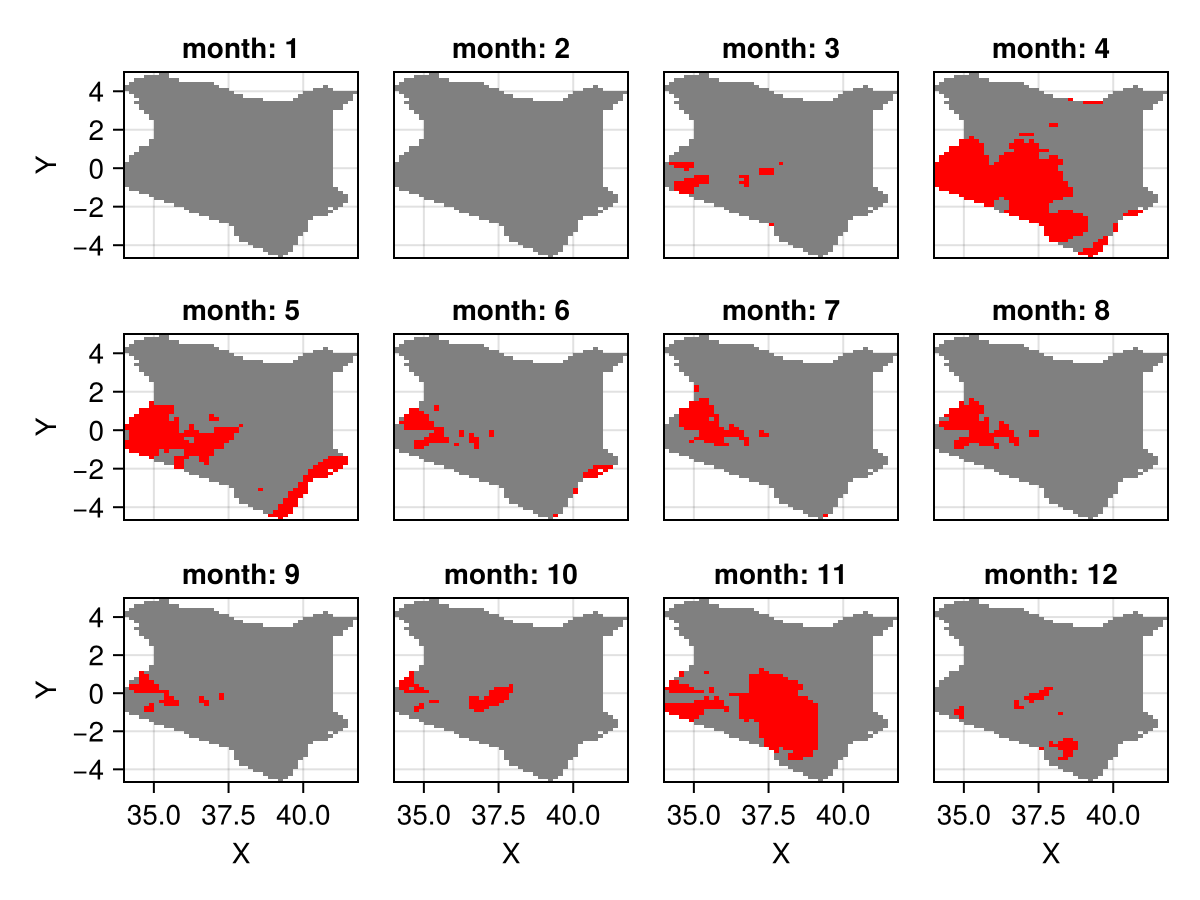

In [44]:
Rasters.rplot(rs_kenya.prec .> monthly_pet .* 0.8, colorrange = (0,1), colormap = [:grey, :red], draw_colorbar = false)

In [45]:
risk_inputs = RasterStack(rs_kenya.tavg, rs_kenya.prec, monthly_pet)

┌ 47×58×12 RasterStack ┐
├──────────────────────┴───────────────────────────────────────────────── dims ┐
  ↓ X     Projected{Float64} 33.999999999999986:0.16666666666666666:41.66666666666666 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 4.833333333333333:-0.16666666666666666:-4.666666666666667 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :tavg eltype: Union{Missing, Float32} dims: X, Y, month size: 47×58×12
  :prec eltype: Union{Missing, Int16} dims: X, Y, month size: 47×58×12
  :pet  eltype: Union{Missing, Float64} dims: X, Y, month size: 47×58×12
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.999999999999986, 41.83333333333332), Y = (-4.666666666666667, 5.0), month = (1, 12))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,29

# Exercise

Make a monthly risk map for _Fasciola_ transmission in Kenya.

You will need to define a function that takes environmental variables as inputs and returns the risk index. Then, you should apply this function to every grid cell for Kenya.

What are areas at risk of transmission with _Fasciola gigantica_?

# Working with vector data

Like raster data, vector data can come in many different formats, such as shapefile, geopackage, or geojson. 

Whereas for raster data, this is dealt with by wrapped any of this data in the Raster type, for vector data the strategy is a little bit different. There are 

First let's download some data. 

To show just how fast Julia can be, we'll download some pretty big datasets:
- [populated places in Kenya from OpenStreetMap](https://data.humdata.org/dataset/hotosm_ken_populated_places) - with over 20 thousand entries
- 100 meter resolution population counts from [WorldPop](https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/KEN/ken_ppp_2020.tif)

In [46]:
import Downloads: download

citiesurl = "https://s3.dualstack.us-east-1.amazonaws.com/production-raw-data-api/ISO3/KEN/populated_places/polygons/hotosm_ken_populated_places_polygons_geojson.zip"
popurl = "https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/KEN/ken_ppp_2020.tif"

if !isfile("Kenya_cities.zip")
    download(citiesurl, "Kenya_cities.zip") # download the zip file
    run(`cmd /c tar -xf Kenya_cities.zip`) # unzip the zipfile. If it doesn't work, unzip manually
end

if !isfile("kenya_population.tif")
    download(popurl, "kenya_population.tif")
end

A handy package to load in vector data is GeoDataFrames

This takes lots of file formats including geojson, geoparquet, shapefile, and geoarrow. Some of these require extensions.

`GeoDataFrames.read` just returns a DataFrame, so it is very easy to work with. The spatial information is stored in the `geometry` column, which most packages will automatically detect.

In [47]:
import GeoDataFrames as GDF
cities = GDF.read("hotosm_ken_populated_places_polygons_geojson.geojson")

Row,geometry,name,name:en,place,landuse,population,is_in,source,name:sw,osm_id,osm_type
,IGeometry,String?,String?,String?,String?,String?,String?,String?,String?,Int32,String
1,Geometry: wkbPolygon,Kaningo town,missing,town,missing,missing,missing,missing,missing,1156491998,ways_poly
2,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,591414718,ways_poly
3,Geometry: wkbPolygon,kiigene police station,missing,missing,residential,missing,missing,missing,missing,1043786073,ways_poly
4,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,1158273403,ways_poly
5,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,677257204,ways_poly
6,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,677257205,ways_poly
7,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,475371902,ways_poly
8,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,547022203,ways_poly
9,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,650270576,ways_poly


The population raster is very high-resolution - 100x100 meters. Or over 100 million gridcells!

In [48]:
pop = Raster("kenya_population.tif")

┌ 9573×12220 Raster{Union{Missing, Float32}, 2} ┐
├───────────────────────────────────────────────┴──────────────────────── dims ┐
  ↓ X Projected{Float64} 33.909583213:0.0008333333299905987:41.88624984767001 ForwardOrdered Regular Intervals{Start},
  → Y Projected{Float64} 5.461250179669967:-0.0008333333300327333:-4.721249780000001 ReverseOrdered Regular Intervals{Start}
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => "kenya_population.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (33.909583213, 41.887083181), Y = (-4.721249780000001, 5.462083513))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘
  ↓ →     5.46125   5.46042   5.45958   …  -4.71958   -4.72042   -4.72125
 33.9096   m

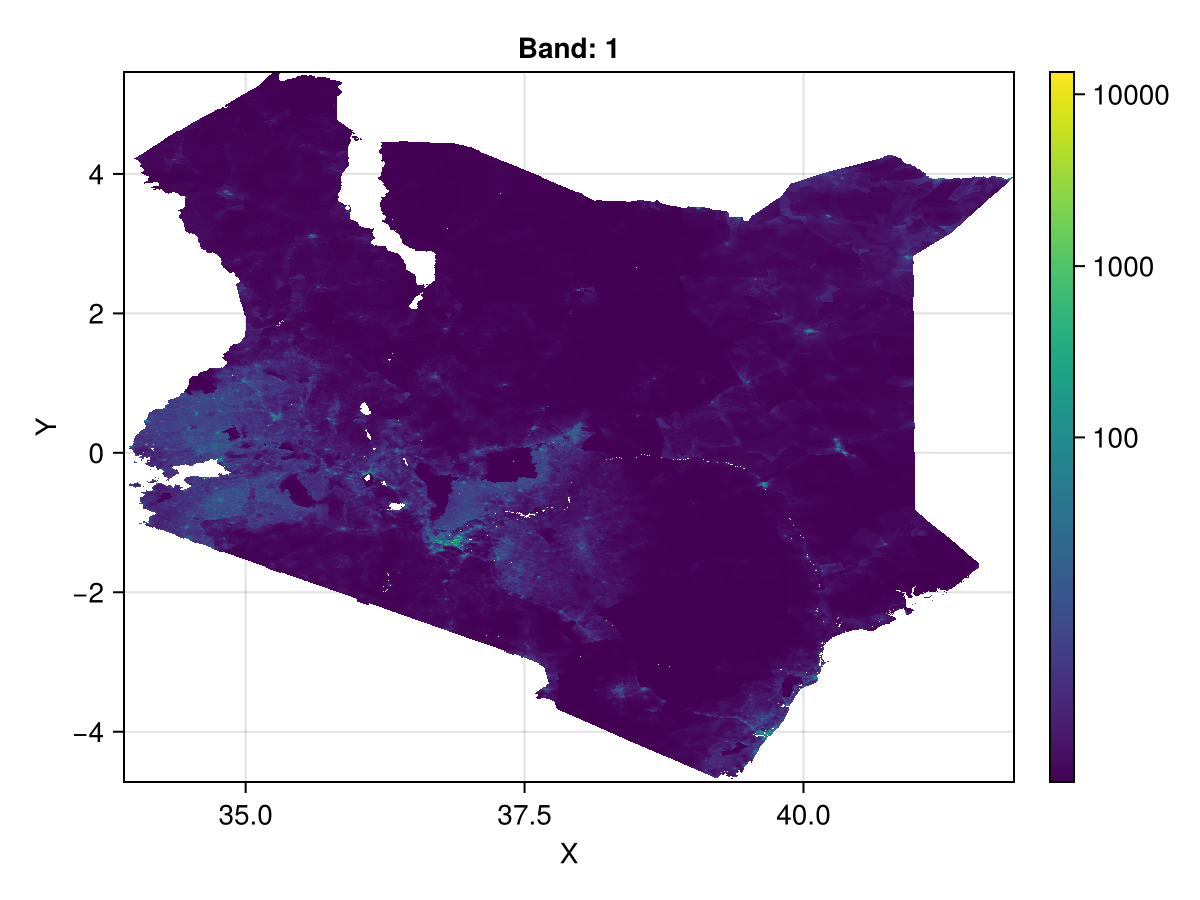

In [49]:
fig, ax, pl = plot(pop; colorscale = Makie.pseudolog10)
Colorbar(fig[1,2], pl; ticks = [100, 1000, 10000])
fig

In [50]:
filter(r -> !ismissing(r.place) && r.place == "city", cities)

Row,geometry,name,name:en,place,landuse,population,is_in,source,name:sw,osm_id,osm_type
,IGeometry,String?,String?,String?,String?,String?,String?,String?,String?,Int32,String
1,Geometry: wkbPolygon,Malindi,missing,city,missing,missing,missing,missing,missing,497879072,ways_poly
2,Geometry: wkbPolygon,Kericho,missing,city,missing,missing,missing,missing,missing,532493084,ways_poly
3,Geometry: wkbPolygon,Meru,missing,city,missing,missing,missing,missing,missing,678380903,ways_poly
4,Geometry: wkbPolygon,Embu,missing,city,residential,missing,"Eastern Province,Kenya",missing,missing,178863862,ways_poly
5,Geometry: wkbPolygon,Kabarnet,missing,city,missing,missing,missing,missing,missing,884306312,ways_poly
6,Geometry: wkbPolygon,Machakos,missing,city,missing,missing,missing,missing,missing,677837974,ways_poly
7,Geometry: wkbPolygon,Nakuru,missing,city,missing,missing,missing,local knowledge,missing,660639213,ways_poly
8,Geometry: wkbMultiPolygon,Kisumu,missing,city,missing,1155574,missing,missing,missing,16193530,relations


The package `GeometryOps` has lots of useful basic vector data operations and is blazingly fast.

Not all operations are implemented in Julia yet, and in some cases you `GeometryOps` will call `LibGEOS` (it will tell you if that's the case)

In [51]:
import GeometryOps as GO

In [52]:
cities.centroid = GO.centroid.(cities.geometry)

23229-element Vector{Tuple{Float64, Float64}}:
 (38.33565890807848, -0.2095569967690358)
 (35.13530118169908, -0.43279309157585755)
 (37.797538696284406, 0.024801062242792448)
 (38.213127455829024, -0.3056352966360525)
 (37.98008447851159, -0.157604394276154)
 (37.96842588165222, -0.1508918727277812)
 (35.471351226677136, -1.125466358969787)
 (35.40197148367301, -0.7839617897077871)
 (35.381710280657565, -0.8320099977381028)
 (35.38139780767557, -0.8315757765641438)
 ⋮
 (39.58422192679766, -4.297787021077106)
 (36.79428037253118, -2.548629297137017)
 (37.08970227139566, -1.0467512883974857)
 (39.58673949784158, -4.292331680533978)
 (39.58919555252226, -4.287988944329652)
 (39.58041529225388, -4.30559635999962)
 (41.58347794412223, -1.6351921641439389)
 (39.57716924812309, -4.272946203623002)
 (39.57858267331193, -4.243762040829587)

## Extracting values from a Raster

Rasters.jl defines an `extract` function that extracts point data from a Raster, and is incredibly fast.

In [53]:
cities_elevation = extract(elev, cities.centroid, skipmissing = true) |> DataFrame

Row,geometry,elev
,Tuple…,Int16
1,"(38.3357, -0.209557)",541
2,"(35.1353, -0.432793)",1700
3,"(37.7975, 0.0248011)",1283
4,"(38.2131, -0.305635)",565
5,"(37.9801, -0.157604)",758
6,"(37.9684, -0.150892)",758
7,"(35.4714, -1.12547)",1978
8,"(35.402, -0.783962)",2100
9,"(35.3817, -0.83201)",2100


In [54]:
cities.elevation = cities_elevation.elev
cities

Row,geometry,name,name:en,place,landuse,population,is_in,source,name:sw,osm_id,osm_type,centroid,elevation
,IGeometry,String?,String?,String?,String?,String?,String?,String?,String?,Int32,String,Tuple…,Int16
1,Geometry: wkbPolygon,Kaningo town,missing,town,missing,missing,missing,missing,missing,1156491998,ways_poly,"(38.3357, -0.209557)",541
2,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,591414718,ways_poly,"(35.1353, -0.432793)",1700
3,Geometry: wkbPolygon,kiigene police station,missing,missing,residential,missing,missing,missing,missing,1043786073,ways_poly,"(37.7975, 0.0248011)",1283
4,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,1158273403,ways_poly,"(38.2131, -0.305635)",565
5,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,677257204,ways_poly,"(37.9801, -0.157604)",758
6,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,677257205,ways_poly,"(37.9684, -0.150892)",758
7,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,475371902,ways_poly,"(35.4714, -1.12547)",1978
8,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,547022203,ways_poly,"(35.402, -0.783962)",2100
9,Geometry: wkbPolygon,missing,missing,missing,residential,missing,missing,missing,missing,650270576,ways_poly,"(35.3817, -0.83201)",2100


Just to show how fast Rasters can be - here we calculate the total population of each of the 23 thousand polygons, across our 100 meter resolution raster.

In [55]:
@time cities.population = zonal(sum, worldpop; of = cities.geometry)

UndefVarError: UndefVarError: `worldpop` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [56]:
scatter(log.(cities.population), cities.elevation)

MethodError: MethodError: no method matching log(::String)
The function `log` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  log(!Matched::Irrational{:ℯ})
   @ Base mathconstants.jl:143
  log(!Matched::Irrational{:ℯ}, !Matched::Number)
   @ Base mathconstants.jl:144
  log(!Matched::Missing, !Matched::Missing)
   @ Base math.jl:1537
  ...


# Eager and lazy loading
One key feature of the Rasters package is that it can easily handle data without ever looking at them - this is known as lazy operations.

For example, you could have a huge dataset on the web or on your computer, that you only want to download a little bit of, or that is just to big to fit in RAM. If you load this data lazily, you can look at it and even change it, but the operations only happen when needed (e.g. when calling `read`, when plotting, or when writing to disk).

Let's repeat some of the analysis above - but now without every loading all the data into memory. We do this just by adding lazy = true.

In [57]:
lazy_bioc = RasterSeries(WorldClim{Climate}, (:tavg, :prec, :srad); month = 1:12, lazy = true)

┌ 12-element RasterSeries{RasterStack,1} ┐
├────────────────────────────────────────┴─────────────────────────────── dims ┐
  ↓ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
  filename: (tavg = ".\\WorldClim\\Climate\\tavg\\wc2.1_10m_tavg_01.tif", prec = ".\\WorldClim\\Climate\\prec\\wc2.1_10m_prec_01.tif", srad = ".\\WorldClim\\Climate\\srad\\wc2.1_10m_srad_01.tif")
└──────────────────────────────────────────────────────────────────────────────┘
  1  …  RasterStack{(:tavg, :prec, :srad), @NamedTuple{tavg::Union{Missing, Float32}, prec::Union{Missing, Int16}, srad::Union{Missing, UInt16}}, 2, @NamedTuple{tavg::SubDiskArray{Union{Missing, Float32}, 2, FileArray{GDALsource, Union{Missing, Float32}, 3, Symbol, Nothing, GridChunks{3

You can check if a Raster is lazy or not using `Rasters.isdisk`. If that returns `true`, it means the Raster is on-disk, i.e. lazy. Internally, a lazy raster doesn't contain the data itself, but just a reference to the location of the file.

In [58]:
lazy_rs = Rasters.combine(lazy_bioc)
Rasters.isdisk(lazy_rs)

true

Rasters will avoid loading in any data until it really has to. It is even possible to do operations on the data without loading it. Then the Raster just stores the location of the file, and the operations we have applied to it.

When printing a Raster, you will notice it doesn't show any of the data as you are used to by now. Because showing the data would involve accessing the file!

In [59]:
lazy_rs.tavg .+ 1

┌ 2160×1080×12 Raster{Union{Missing, Float32}, 3} ┐
├─────────────────────────────────────────────────┴────────────────────── dims ┐
  ↓ X     Projected{Float64} -180.0:0.16666666666666666:179.83333333333331 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 89.83333333333333:-0.16666666666666666:-90.0 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => ".\\WorldClim\\Climate\\tavg\\wc2.1_10m_tavg_01.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0), month = (1, 12))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘


A call to the hargreaves function we defined above is still lazy - meaning we don't actually calculate anything yet. The raster could be giant and it won't take any time (yet).

In [60]:
lazy_hargreaves = hargreaves.(lazy_rs.tavg, lazy_rs.srad)

┌ 2160×1080×12 Raster{Union{Missing, Float64}, 3} ┐
├─────────────────────────────────────────────────┴────────────────────── dims ┐
  ↓ X     Projected{Float64} -180.0:0.16666666666666666:179.83333333333331 ForwardOrdered Regular Intervals{Start},
  → Y     Projected{Float64} 89.83333333333333:-0.16666666666666666:-90.0 ReverseOrdered Regular Intervals{Start},
  ↗ month Sampled{Int64} 1:12 ForwardOrdered Regular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => ".\\WorldClim\\Climate\\tavg\\wc2.1_10m_tavg_01.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0), month = (1, 12))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘


If a lazy raster is read in, e.g. for writing or calculating the sum, it will do so chunk-wise. This means the whole thing is never read into memory at once - which again makes it possible to work with Rasters that are bigger than the RAM you have available.

In [61]:
Rasters.DiskArrays.eachchunk(lazy_hargreaves)

1×1080×12 DiskArrays.GridChunks{3, Tuple{DiskArrays.RegularChunks, DiskArrays.RegularChunks, DiskArrays.RegularChunks}}:
[:, :, 1] =
 (1:2160, 1:1, 1:1)  (1:2160, 2:2, 1:1)  …  (1:2160, 1080:1080, 1:1)

[:, :, 2] =
 (1:2160, 1:1, 2:2)  (1:2160, 2:2, 2:2)  …  (1:2160, 1080:1080, 2:2)

[:, :, 3] =
 (1:2160, 1:1, 3:3)  (1:2160, 2:2, 3:3)  …  (1:2160, 1080:1080, 3:3)

;;; … 

[:, :, 10] =
 (1:2160, 1:1, 10:10)  (1:2160, 2:2, 10:10)  …  (1:2160, 1080:1080, 10:10)

[:, :, 11] =
 (1:2160, 1:1, 11:11)  (1:2160, 2:2, 11:11)  …  (1:2160, 1080:1080, 11:11)

[:, :, 12] =
 (1:2160, 1:1, 12:12)  (1:2160, 2:2, 12:12)  …  (1:2160, 1080:1080, 12:12)

Tiff files often have row-wise or column-wise chunks - which is quite inefficient. When writing, you can easily specify the chunking pattern you want to write to.

In [63]:
hargreaves_tif = set(lazy_hargreaves, :month => Rasters.Band) # .tif files can only have X,Y,Band dimensions

┌ 2160×1080×12 Raster{Union{Missing, Float64}, 3} ┐
├─────────────────────────────────────────────────┴────────────────────── dims ┐
  ↓ X    Projected{Float64} -180.0:0.16666666666666666:179.83333333333331 ForwardOrdered Regular Intervals{Start},
  → Y    Projected{Float64} 89.83333333333333:-0.16666666666666666:-90.0 ReverseOrdered Regular Intervals{Start},
  ↗ Band Sampled{Int64} 1:12 ForwardOrdered Regular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => ".\\WorldClim\\Climate\\tavg\\wc2.1_10m_tavg_01.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (-180.0, 179.99999999999997), Y = (-90.0, 90.0), Band = (1, 12))
  crs: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722...
└──────────────────────────────────────────────────────────────────────────────┘


In [ ]:
write("hargreaves.tif", hargreaves_tif, chunks = (X(128), Y(128)))

┌ Info: `missingval` set to -Inf on disk
└ @ Rasters C:\Users\tsh371\.julia\packages\Rasters\UTSRc\src\utils.jl:92


"hargreaves.tif"